In this notebook, we will finally create predictive features using the logs we cleaned on notebook 2.2. Our focus, for now, will be prediction using an aggregate non-temporal representation of each student.

Throughout the notebook, we will start with the import of logs and remaining tables that we consider to be relevant for feature engineering and extraction.

#### 1. Importing the relevant packages, setting global variables and importing the relevant files

In [1]:
#import libs
import pandas as pd
import numpy as np

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

#starting with other tools
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/Modeling Stage/R_Gonz_cleaned_logs.csv', 
                           dtype = {
                                   'id': object,
                                   'itemid': object,
                                   'userid': object,
                                   'course': object,
                                   'cmid': object,
                                   },
                                   parse_dates = ['time'],).drop(['Unnamed: 0', 'id', 'url', 'info'], axis = 1).dropna(how = 'all', axis = 1) #logs

#loading support table
support_table = pd.read_csv('../Data/R_Gonz_support_table.csv', 
                           dtype = {
                                   'assign_id': object,
                                   'courseid': object,
                                   'userid': object,
                                   }, 
                            parse_dates = ['sup_time', 'startdate']).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1)

#save tables 
class_list = pd.read_csv('../Data/Modeling Stage/R_Gonz_class_duration.csv', 
                         dtype = {
                                   'course': object,                                   
                                   },
                        parse_dates = ['Start Date','End Date', 'cuttoff_point']).drop('Unnamed: 0', axis = 1).rename(columns = {'cuttoff_point' : 'Week before start'})

#targets tables 
targets_table = pd.read_csv('../Data/Modeling Stage/R_Gonz_targets_table.csv',
                           dtype = {
                                   'userid': object,
                                   'courseid': object,
                                   },)

We'll start with the general verification of the different datasets we've imported. 

**Starting with the targets table, which includes all valid student-course logs with Final-Grade.**

In [4]:
#get info
targets_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30510 entries, 0 to 30509
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   courseid         30510 non-null  object 
 1   userid           30510 non-null  object 
 2   Grade Mandatory  26676 non-null  float64
 3   Grade Optional   16485 non-null  float64
 4   final_mark       30510 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.2+ MB


In [5]:
targets_table.describe(include = 'all', datetime_is_numeric = True)

courseid   userid  Grade Mandatory  Grade Optional    final_mark
count     30510    30510     26676.000000    16485.000000  30510.000000
unique      732    14111              NaN             NaN           NaN
top      2271.0  36779.0              NaN             NaN           NaN
freq        667       10              NaN             NaN           NaN
mean        NaN      NaN         0.303199        0.086236      4.715297
std         NaN      NaN         0.151369        0.144909      3.121882
min         NaN      NaN         0.000000        0.000000      0.000000
25%         NaN      NaN         0.210688        0.000000      2.194832
50%         NaN      NaN         0.339517        0.000000      4.666666
75%         NaN      NaN         0.424005        0.125375      7.423107
max         NaN      NaN         0.500000        0.500000     10.000000

In [6]:
targets_table.rename(columns = {'courseid' : 'course'}, inplace = True)

Then, we repeat the same for the list of courses and their respective start and end dates. We know that the number of students attending each course is the number found in the logs. We will need to make further cuts 

In [7]:
class_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   course                562 non-null    object        
 1   Users per course      562 non-null    float64       
 2   Start Date            562 non-null    datetime64[ns]
 3   End Date              562 non-null    datetime64[ns]
 4   Course duration days  562 non-null    float64       
 5   Week before start     562 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 26.5+ KB


In [8]:
class_list.describe(include = 'all', datetime_is_numeric = True)

course  Users per course                     Start Date  \
count      562        562.000000                            562   
unique     562               NaN                            NaN   
top     1000.0               NaN                            NaN   
freq         1               NaN                            NaN   
mean       NaN         51.046263  2014-11-16 17:51:01.921708288   
min        NaN          1.000000            2014-08-24 00:00:00   
25%        NaN         17.000000            2014-09-09 00:00:00   
50%        NaN         34.000000            2014-10-20 00:00:00   
75%        NaN         69.000000            2015-01-24 18:00:00   
max        NaN        642.000000            2015-06-01 00:00:00   
std        NaN         56.567043                            NaN   

                             End Date  Course duration days  \
count                             562            562.000000   
unique                            NaN                   NaN   
top                               NaN                   NaN   
freq                              NaN                   NaN   
mean    2015-03-17 21:26:15.800711680            122.149466   
min               2014-10-01 00:00:00             29.000000   
25%               2015-01-15 00:00:00             98.000000   
50%               2015-02-25 00:00:00            122.000000   
75%               2015-05-25 00:00:00            137.000000   
max               2015-07-10 00:00:00            306.000000   
std                               NaN             47.997650   

                    Week before start  
count                             562  
unique                            NaN  
top                               NaN  
freq                              NaN  
mean    2014-11-09 17:51:01.921708288  
min               2014-08-17 00:00:00  
25%               2014-09-02 00:00:00  
50%               2014-10-13 00:00:00  
75%               2015-01-17 18:00:00  
max               2015-05-25 00:00:00  
std                               NaN

In [9]:
class_list

course  Users per course Start Date   End Date  Course duration days  \
0    1000.0              12.0 2014-08-31 2015-01-19                 142.0   
1    1002.0              22.0 2014-09-28 2015-03-04                 158.0   
2    1010.0              48.0 2014-09-11 2014-12-22                 103.0   
3    1013.0              71.0 2014-09-23 2015-02-02                 133.0   
4    1020.0              64.0 2015-01-11 2015-06-04                 145.0   
..      ...               ...        ...        ...                   ...   
557   984.0              13.0 2014-08-31 2015-01-27                 150.0   
558   985.0              22.0 2014-08-24 2015-02-25                 186.0   
559   992.0              16.0 2015-02-09 2015-05-12                  93.0   
560   993.0              55.0 2014-09-11 2015-01-12                 124.0   
561   999.0              59.0 2014-09-15 2015-01-29                 137.0   

    Week before start  
0          2014-08-24  
1          2014-09-21  
2          2014-09-04  
3          2014-09-16  
4          2015-01-04  
..                ...  
557        2014-08-24  
558        2014-08-17  
559        2015-02-02  
560        2014-09-04  
561        2014-09-08  

[562 rows x 6 columns]

We still note a significant presence of courses with small numbers of students. The first step we will take is the removal of all courses whose number of attending students is below 50.

In [10]:
class_list = class_list[class_list['Users per course'] >= 50]

#updating student logs
student_logs = student_logs[student_logs['course'].isin(class_list['course'])]


#additionally updating targets_table
targets_table = targets_table[targets_table['course'].isin(class_list['course'])]
class_list.describe(include = 'all', datetime_is_numeric = True)

course  Users per course           Start Date             End Date  \
count      225        225.000000                  225                  225   
unique     225               NaN                  NaN                  NaN   
top     1013.0               NaN                  NaN                  NaN   
freq         1               NaN                  NaN                  NaN   
mean       NaN         95.902222  2014-11-14 09:42:24  2015-03-21 06:49:36   
min        NaN         50.000000  2014-08-31 00:00:00  2014-10-05 00:00:00   
25%        NaN         62.000000  2014-09-08 00:00:00  2015-01-17 00:00:00   
50%        NaN         76.000000  2014-10-21 00:00:00  2015-02-09 00:00:00   
75%        NaN        107.000000  2015-01-24 00:00:00  2015-05-28 00:00:00   
max        NaN        642.000000  2015-05-19 00:00:00  2015-06-30 00:00:00   
std        NaN         66.423756                  NaN                  NaN   

        Course duration days    Week before start  
count             225.000000                  225  
unique                   NaN                  NaN  
top                      NaN                  NaN  
freq                     NaN                  NaN  
mean              127.880000  2014-11-07 09:42:24  
min                31.000000  2014-08-24 00:00:00  
25%               106.000000  2014-09-01 00:00:00  
50%               128.000000  2014-10-14 00:00:00  
75%               140.000000  2015-01-17 00:00:00  
max               295.000000  2015-05-12 00:00:00  
std                47.412596                  NaN

We'll follow up with taking a closer look logs we cleaned in the previous section. 

In [11]:
student_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5160303 entries, 4845 to 6869430
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   userid  object        
 2   ip      object        
 3   course  object        
 4   module  object        
 5   cmid    object        
 6   action  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 315.0+ MB


In [12]:
student_logs.describe(include = 'all', datetime_is_numeric = True)

time   userid         ip   course   module  \
count                         5160303  5160303    5160303  5160303  5160303   
unique                            NaN    10700      58859      225       29   
top                               NaN  47527.0  127.0.0.1   2059.0   course   
freq                              NaN    40537    3097736   129398  2107635   
mean    2015-01-16 19:08:28.543642880      NaN        NaN      NaN      NaN   
min               2014-09-01 18:53:34      NaN        NaN      NaN      NaN   
25%               2014-11-10 12:11:47      NaN        NaN      NaN      NaN   
50%               2015-01-12 08:29:46      NaN        NaN      NaN      NaN   
75%               2015-03-23 14:54:55      NaN        NaN      NaN      NaN   
max               2015-06-29 23:24:54      NaN        NaN      NaN      NaN   

           cmid   action  
count   5160303  5160303  
unique    14050       94  
top         0.0     view  
freq    2358478  4079092  
mean        NaN      NaN  
min         NaN      NaN  
25%         NaN      NaN  
50%         NaN      NaN  
75%         NaN      NaN  
max         NaN      NaN

In [13]:
student_logs

time   userid         ip  course    module      cmid  \
4845    2014-09-01 18:53:34  47196.0  127.0.0.1  2055.0    course       0.0   
4846    2014-09-01 18:53:39  47196.0  127.0.0.1  2055.0  resource   85645.0   
4847    2014-09-01 18:53:56  47196.0  127.0.0.1  2055.0    course       0.0   
4848    2014-09-01 18:54:01  47196.0  127.0.0.1  2055.0    course       0.0   
4849    2014-09-01 18:54:06  47196.0  127.0.0.1  2055.0      user       0.0   
...                     ...      ...        ...     ...       ...       ...   
6868776 2015-06-15 15:37:19  54662.0  127.0.0.1  3094.0    course       0.0   
6868777 2015-06-15 15:37:38  54662.0  127.0.0.1  3094.0    course       0.0   
6869428 2015-06-18 08:57:58  52262.0  127.0.0.1  2411.0    course       0.0   
6869429 2015-06-18 08:58:35  52262.0  127.0.0.1  2411.0  resource  105562.0   
6869430 2015-06-18 08:59:50  52262.0  127.0.0.1  2411.0    course       0.0   

           action  
4845         view  
4846         view  
4847         view  
4848         view  
4849     view all  
...           ...  
6868776      view  
6868777      view  
6869428      view  
6869429      view  
6869430      view  

[5160303 rows x 7 columns]

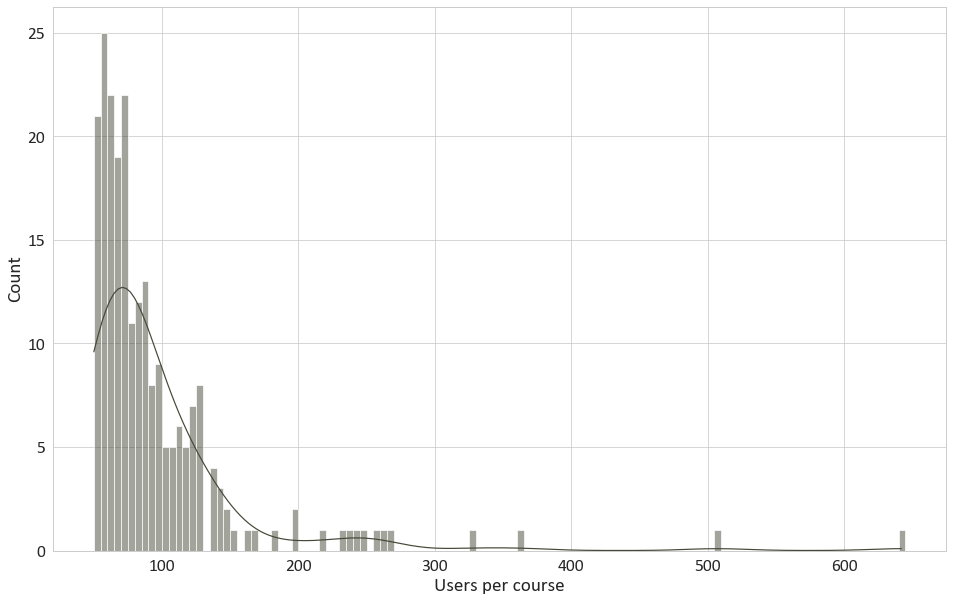

In [14]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)
hist4 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist4.get_figure()
fig.savefig('../Images/hist4_students_per_course_bin_5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist4


Likewise, there is some attention to be found on courses with abnormally high numbers of attending students in a face-to-face context (over 200). We will pay closer attention to those courses.

In [15]:
#create df only with high affluence courses
most_affluent_courses = class_list[class_list['Users per course'] >= 200]

#separate logs accordingly
high_attendance_logs = student_logs[student_logs['course'].isin(most_affluent_courses['course'])]
high_attendance_logs

time   userid         ip  course    module      cmid  \
37257   2014-09-03 10:32:56  69599.0  127.0.0.1  2007.0    course       0.0   
37258   2014-09-03 10:33:10  69599.0  127.0.0.1  2007.0      user       0.0   
37259   2014-09-03 10:39:27  69599.0  127.0.0.1  2007.0    course       0.0   
37260   2014-09-03 10:42:23  69599.0  127.0.0.1  2007.0    course       0.0   
37261   2014-09-03 10:42:28  69599.0  127.0.0.1  2007.0  resource   83279.0   
...                     ...      ...        ...     ...       ...       ...   
6851482 2015-06-23 13:44:08  47237.0  127.0.0.1  3022.0    course       0.0   
6851483 2015-06-28 13:59:04  47237.0  127.0.0.1  3022.0    course       0.0   
6869428 2015-06-18 08:57:58  52262.0  127.0.0.1  2411.0    course       0.0   
6869429 2015-06-18 08:58:35  52262.0  127.0.0.1  2411.0  resource  105562.0   
6869430 2015-06-18 08:59:50  52262.0  127.0.0.1  2411.0    course       0.0   

           action  
37257        view  
37258    view all  
37259        view  
37260        view  
37261        view  
...           ...  
6851482      view  
6851483      view  
6869428      view  
6869429      view  
6869430      view  

[812003 rows x 7 columns]

In [16]:
high_attendance_logs.describe(include = 'all', datetime_is_numeric = 'all')

time   userid         ip  course  module  \
count                          812003   812003     812003  812003  812003   
unique                            NaN     2680       8729      12      15   
top                               NaN  63280.0  127.0.0.1  2059.0  course   
freq                              NaN     2982     608123  129398  356245   
mean    2015-02-16 20:29:18.531203072      NaN        NaN     NaN     NaN   
min               2014-09-03 10:32:56      NaN        NaN     NaN     NaN   
25%        2014-12-11 22:41:04.500000      NaN        NaN     NaN     NaN   
50%               2015-03-04 17:32:30      NaN        NaN     NaN     NaN   
75%        2015-04-20 09:49:38.500000      NaN        NaN     NaN     NaN   
max               2015-06-28 23:23:50      NaN        NaN     NaN     NaN   

          cmid  action  
count   812003  812003  
unique    1001      34  
top        0.0    view  
freq    374609  673457  
mean       NaN     NaN  
min        NaN     NaN  
25%        NaN     NaN  
50%        NaN     NaN  
75%        NaN     NaN  
max        NaN     NaN

We can plot the weekly interactions of these courses.

In [17]:
#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs.groupby([pd.Grouper(key='time', freq='W'), 'course']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['course'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index('Course', drop = True)
grouped_data.T.describe(include = 'all').T

count         mean          std     min      25%     50%       75%  \
Course                                                                       
2007     18.0  2106.055556  1100.755007   116.0  1594.25  1977.5   2705.25   
2024     21.0  3182.571429  1973.936361   233.0  1540.00  2949.0   4940.00   
2059     19.0  6810.421053  4453.744097  1277.0  3700.50  5636.0  10547.50   
2271     18.0  5975.111111  3868.764994   445.0  3792.50  4467.5   9135.25   
2288     19.0  4139.421053  2721.201334  1533.0  2243.50  3173.0   4674.00   
2411     23.0  2794.434783  1978.090122   123.0  1494.00  2555.0   3421.50   
2607     22.0  4725.772727  4132.541383   550.0  2611.50  3851.0   5337.25   
3022     30.0  1465.800000  1372.654700    94.0   247.25  1331.0   1893.00   
3033     19.0  2110.631579  1560.074400   524.0   820.00  1478.0   2935.50   
3069     29.0   750.724138  1011.913424    92.0   226.00   433.0    640.00   
3151     36.0  1300.833333  1283.615107    77.0   149.00  1133.5   1980.75   
690      16.0  4421.562500  2771.970009   934.0  2437.25  3803.0   6353.25   

            max  
Course           
2007     4439.0  
2024     6549.0  
2059    16615.0  
2271    14147.0  
2288    10809.0  
2411     7784.0  
2607    20018.0  
3022     5552.0  
3033     5435.0  
3069     4273.0  
3151     4894.0  
690      9325.0

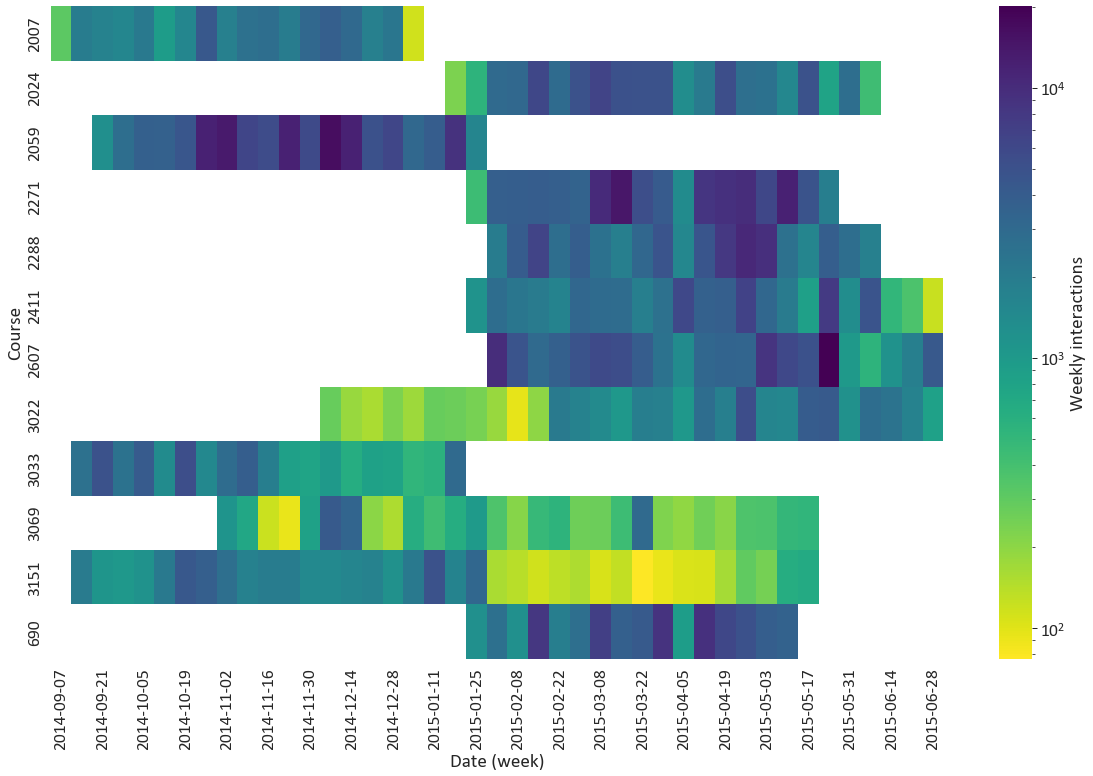

In [18]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat4 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 1,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat4.get_figure()
fig.savefig('../Images/highest_attendance_weekly_clicks_heat4.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat4

While most courses are very clearly restricted to their semester, there are courses that have interactions occurring across the entire year. 

For these courses, we just want to undestand whether all students are interacting continuously or we are speaking of different co-horts of students. As such, we will look more deeply at the following courses:

3022, 3069 and 3151

In [19]:
year_long_high_attendance = ['3022.0', '3069.0', '3151.0']

#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs[high_attendance_logs['course'].isin(year_long_high_attendance)].groupby([pd.Grouper(key='time', freq='W'), 'course', 'userid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['course', 'userid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Course', 'userid'], drop = True)
grouped_data.T.describe(include = 'all').T

count       mean        std  min   25%   50%    75%    max
Course userid                                                             
3022   14727.0   23.0  20.173913  30.986290  1.0  2.50  11.0  19.50  142.0
       19329.0   15.0  21.733333  24.618421  1.0  4.00   8.0  42.00   67.0
       23000.0   19.0  12.526316  10.073995  1.0  3.50  10.0  21.50   33.0
       23427.0   13.0  17.230769  19.110005  2.0  5.00  12.0  17.00   67.0
       26356.0   16.0  14.937500  14.359521  1.0  3.00  11.0  19.75   54.0
...               ...        ...        ...  ...   ...   ...    ...    ...
3151   66551.0   22.0  17.454545  18.712683  1.0  5.00  11.0  26.00   77.0
       71150.0   25.0  27.160000  28.125730  1.0  3.00  21.0  33.00  104.0
       72025.0    8.0   8.625000   4.565007  2.0  5.75   9.0   9.75   17.0
       72952.0    8.0   7.750000   4.621379  1.0  4.75   7.5  10.00   15.0
       74192.0   13.0  17.769231  16.161445  1.0  5.00  13.0  25.00   52.0

[719 rows x 8 columns]

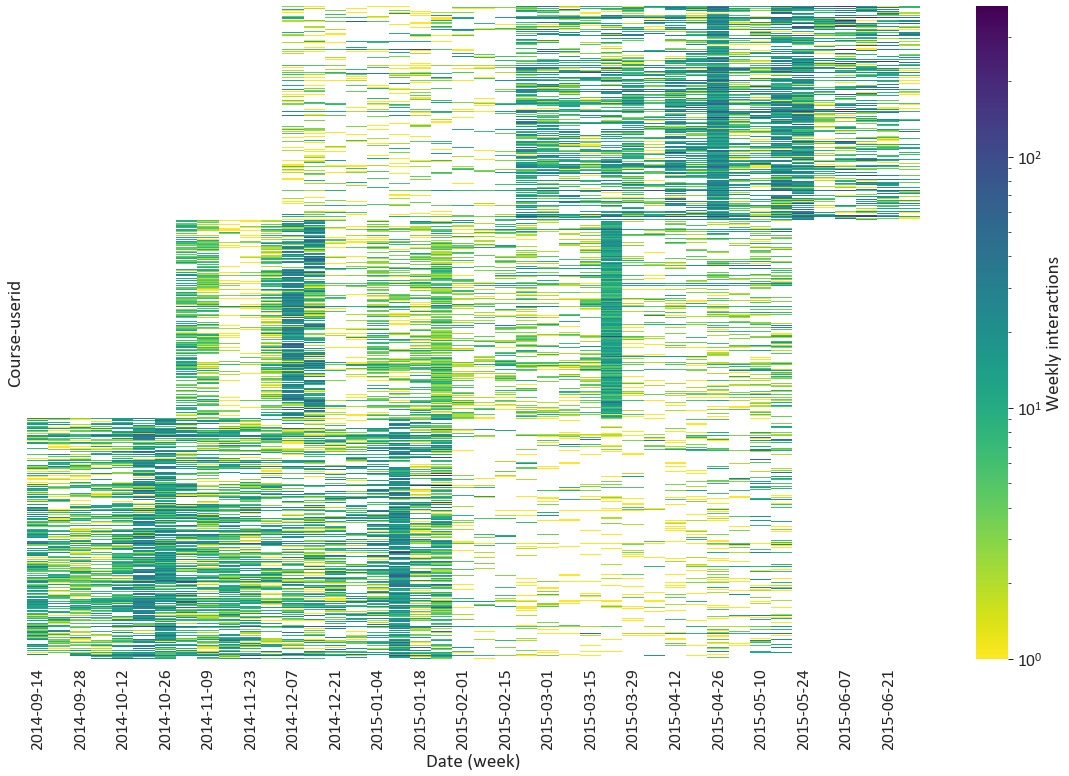

In [20]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat5 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 0,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat5.get_figure()
fig.savefig('../Images/high_attend_yearlong_weekly_heat5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat5, grouped_data, high_attendance_logs, year_long_high_attendance

After consideration, we find that the student interactions seem to be consistent with the course duration. 

We note, however, that the accesses to course 4923 seem to be inconsistent at best. We will monitor this course (and others) in the following steps. For now, we will proceed with the analysis over targets and support table.

**1. First, we filter by our current list of valid courses.**

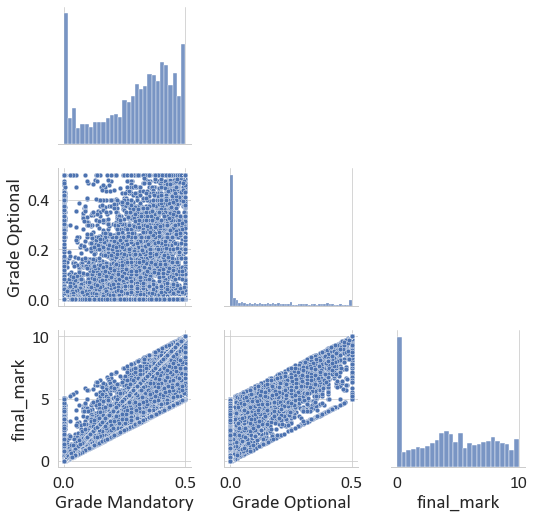

In [21]:
#Representation of different targets depending 
g = sns.PairGrid(targets_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

In [22]:
#a larger overlook at the different courses
targets_table.groupby('course').agg({
                                    'userid' : 'count', 
                                    'Grade Mandatory' : ['min', 'mean', 'max'],
                                    'Grade Optional' : ['min', 'mean', 'max'],                                    
                                    'final_mark' : ['min', 'mean', 'max'],
                                    }).describe(include = 'all')

userid Grade Mandatory                         Grade Optional  \
            count             min        mean         max            min   
count  225.000000      203.000000  203.000000  203.000000     175.000000   
mean    98.013333        0.069314    0.296641    0.438840       0.021212   
std     68.088144        0.112695    0.116563    0.113818       0.073398   
min     50.000000        0.000000    0.001987    0.003375       0.000000   
25%     63.000000        0.000000    0.234911    0.442997       0.000000   
50%     79.000000        0.000042    0.318563    0.485838       0.000000   
75%    109.000000        0.120425    0.383160    0.500000       0.000000   
max    667.000000        0.500000    0.500000    0.500000       0.500000   

                               final_mark                          
             mean         max         min        mean         max  
count  175.000000  175.000000  225.000000  225.000000  225.000000  
mean     0.107867    0.265387    0.858859    4.470493    7.800738  
std      0.136104    0.208401    1.736258    2.526421    2.676416  
min      0.000000    0.000000    0.000000    0.002941    0.128000  
25%      0.000293    0.009250    0.000000    2.582930    6.002083  
50%      0.047349    0.309211    0.000000    4.420961    9.027182  
75%      0.181510    0.475429    0.700000    6.391660   10.000000  
max      0.500000    0.500000   10.000000   10.000000   10.000000

#### Finally, we will take a look at the support table we have and repeat the same steps performed thus far

In [23]:
#separate logs accordingly
support_table = support_table[support_table['courseid'].isin(class_list['course'])]

#get info
support_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175955 entries, 219 to 220922
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   assign_id         175955 non-null  object        
 1   courseid          175955 non-null  object        
 2   startdate         175955 non-null  datetime64[ns]
 3   userid            175955 non-null  object        
 4   sup_time          175955 non-null  datetime64[ns]
 5   mandatory_status  175955 non-null  float64       
 6   delivered         175955 non-null  int64         
 7   assignment_mark   175955 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 12.1+ MB


In [24]:
support_table.describe(include = 'all', datetime_is_numeric = True)

assign_id courseid                      startdate   userid  \
count     175955   175955                         175955   175955   
unique      3194      225                            NaN    10913   
top      98648.0   2271.0                            NaN  72925.0   
freq         657    17871                            NaN      121   
mean         NaN      NaN  2014-11-25 02:02:52.946491904      NaN   
min          NaN      NaN            2014-08-31 22:00:00      NaN   
25%          NaN      NaN            2014-09-09 22:00:00      NaN   
50%          NaN      NaN            2014-12-10 23:00:00      NaN   
75%          NaN      NaN            2015-01-26 23:00:00      NaN   
max          NaN      NaN            2015-05-19 22:00:00      NaN   
std          NaN      NaN                            NaN      NaN   

                             sup_time  mandatory_status      delivered  \
count                          175955     175955.000000  175955.000000   
unique                            NaN               NaN            NaN   
top                               NaN               NaN            NaN   
freq                              NaN               NaN            NaN   
mean    2015-02-11 04:08:19.686510592          0.525345       0.573868   
min               2014-09-04 16:41:44          0.000000       0.000000   
25%               2014-12-07 22:48:31          0.000000       0.000000   
50%               2015-02-21 13:34:16          1.000000       1.000000   
75%        2015-04-20 22:18:22.500000          1.000000       1.000000   
max               2015-07-22 21:59:22          1.000000       1.000000   
std                               NaN          0.499359       0.494515   

        assignment_mark  
count     175955.000000  
unique              NaN  
top                 NaN  
freq                NaN  
mean           0.385605  
min            0.000000  
25%            0.000000  
50%            0.200000  
75%            0.800000  
max            1.000000  
std            0.410696

In [25]:
support_table

assign_id courseid           startdate   userid            sup_time  \
219       5196.0    174.0 2014-09-08 22:00:00  52123.0 2014-11-18 14:56:51   
220       5196.0    174.0 2014-09-08 22:00:00  57173.0 2014-11-18 14:46:09   
221       5196.0    174.0 2014-09-08 22:00:00  60625.0 2014-11-18 15:04:49   
222       5196.0    174.0 2014-09-08 22:00:00  60643.0 2014-11-18 14:44:08   
223       5196.0    174.0 2014-09-08 22:00:00  60694.0 2014-11-18 14:48:36   
...          ...      ...                 ...      ...                 ...   
220918  272791.0   5646.0 2015-02-04 23:00:00  55804.0 2015-05-27 15:17:53   
220919  272791.0   5646.0 2015-02-04 23:00:00  60489.0 2015-05-22 16:09:00   
220920  272791.0   5646.0 2015-02-04 23:00:00  66527.0 2015-05-27 19:41:48   
220921  272791.0   5646.0 2015-02-04 23:00:00  77034.0 2015-05-27 14:32:56   
220922  272791.0   5646.0 2015-02-04 23:00:00  77055.0 2015-05-27 15:33:21   

        mandatory_status  delivered  assignment_mark  
219                  1.0          1         0.702970  
220                  1.0          1         0.653465  
221                  1.0          1         0.851485  
222                  1.0          1         0.752475  
223                  1.0          1         0.752475  
...                  ...        ...              ...  
220918               1.0          1         0.900000  
220919               1.0          1         0.300000  
220920               1.0          1         0.900000  
220921               1.0          1         1.000000  
220922               1.0          1         0.900000  

[175955 rows x 8 columns]

In [26]:
#a larger overlook at the different courses
support_table.groupby('courseid').agg({
                                    'userid' : 'count',
                                    'assign_id' : 'count', 
                                    'mandatory_status' : 'mean',
                                    'delivered' : 'mean',                                    
                                    'assignment_mark' : 'mean',
                                    }).describe(include = 'all')

userid     assign_id  mandatory_status   delivered  \
count    225.000000    225.000000        225.000000  225.000000   
mean     782.022222    782.022222          0.646406    0.693950   
std     1386.200709   1386.200709          0.355974    0.319687   
min       52.000000     52.000000          0.000000    0.001969   
25%      229.000000    229.000000          0.323944    0.454545   
50%      469.000000    469.000000          0.794562    0.812500   
75%      891.000000    891.000000          0.985915    0.993243   
max    17871.000000  17871.000000          1.000000    1.000000   

       assignment_mark  
count       225.000000  
mean          0.463854  
std           0.275016  
min           0.000394  
25%           0.217917  
50%           0.487383  
75%           0.683895  
max           1.000000

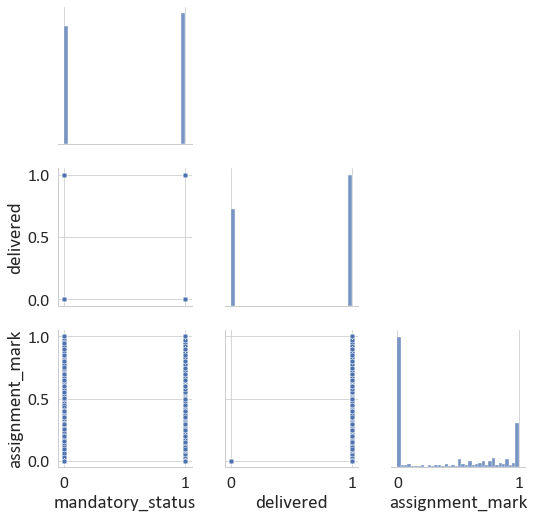

In [27]:
#Representation of different targets depending 
g = sns.PairGrid(support_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

**Going forward**.

After this preliminary look, we will go forward with extracting features from the Moodle logs. 

In this notebook, we will consider a static non-temporal representation that considers each student-course pair as a row. We will, however, construct different datasets - 1 for each relevant timestep. 

We will rely on features that are regular presences in the literature. Some of these features may appear in more than one work:

**From Macfadyen et al. (2010)**

Count related features:
- Discussion messages posted, 
- Online Sessions, 
- File views,
- Assessments finished, 
- Assessments started, 
- Replies to discussion messages, 
- Mail messages sent, 
- Assignments submitted, 
- Discussion MEssages read, 
- Web link views

Time related features:
- Total time online, 
- Time spent on assignments,


**From Romero et al. (2013)**

Number Accesses to:
- Assignments done,
- Quizzes passed,
- Quizzes failed,
- Forum messages posted, 
- Forum messages read,

Time related features:
- Total time on assignments, 
- Total time on quizzes, 
- Total time on forums

**From Gasevic et. al (2016)**

Number of Accesses of the following variables:
- course logins,
- forum,
- resources,
- Turnitin file submission,
- assignments,
- book,
- quizzes, 
- feedback,
- lessons,
- virtual classroom
- chat,

- etc...

**From Conijn et. al (2017)**

Click count related features:
- Clicks,
- Online sessions, 
- Course page views,
- Resources viewed,
- Links viewed, 
- Discussion post views,
- Content page views,
- Quizzes,
- Quizzes passed,
- Assignments submitted, 
- Wiki edits,
- Wiki views,

Time related features:
- Total time online,
- Largest period of inactivity,
- Time until first action, 
- Averages session time,

Performance related features:
- Average assignment grade,

**Chen and Cui (2020)**

Click count related features:
- Total clicks, 
- Clicks on campus, 
- Online sessions,
- Clicks during weekdays,
- Clicks on weekend,
- Assignments, 
- File,
- Forum,
- Overview Report,
- Quizz,
- System, 
- User Report

Time related features
- Total time of online sessions, 
- Mean duration of online sessions, 
- SD of time between sessions, 
- Total time on Quiz, 
- Total time on File, 
- SD of time on File, 

Other statistics
- Ratio between on-campups and off-campus clicks

**Nuno Rosário Thesis**
- number of forum messages read, 
- number of forum messages posted, 
- number of pages,
- number of clicks, 
- number of submissions,
- number of files accessed,

As stated, some of the features are calculated across multiple works - and these only address the course level. They are not designed specifically for course-agnostic purposes.

First, **we will split the logs by the difference courses and, for each student calculate the different features we intend to calculate.** The are calculated via aggregate operations, from the most common (appear more times in our literature).

**But before that**, we will look at different columns of our logs and, when appropriate, keep the different values they may take. The first, and most immediate correction is IP - 127.0.0.1 hints at local connection, while other IPs suggest an out of Campus connection. 

In [28]:
#converts up to on_campus
student_logs['on_campus'] = np.where(student_logs['ip'] == '127.0.0.1', 1, 0)
student_logs.drop('ip', axis = 1, inplace = True)

Secondly, we take a look at the actions and the modules. Here, we can find the most common actions and modules.

We are familiar with the most common features: course, resources, assignments, quiz, forums, etc...

There are, however, other less common labels whose usage is not very common. We can, start by grouping together the less common modules together in a way that, at least intuitively, makes sense.

In [29]:
#other pages with unclear meaning will be grouped together
other_modules = ['oublog', 'data', 'data', 'bigbluebuttonbn', 'nanogong', 'role', 'notes', 'calendar', 'recordingsbn', 'bookmark']

#converts discussion points to forum or, alternatively,groups other elements to other category
student_logs['module'] = np.where(student_logs['module'] == 'discussion', 'forum',
                                  np.where(student_logs['module'] == 'imscp', 'resource', #imscp is what allows content packages to be posted
                                  np.where(student_logs['module'].isin(other_modules), 'others', student_logs['module'])))

del other_modules

Likewise, we will need to take a look at the different actions in order to understand how common these may be. 

Again, we will look at different actions and see how we can group them together in a way that, at least, makes intuitive sense. There is use in keeping the distinction between different types of view.

In [30]:
#updates and edits related to making editions on presented information:
update_related = ['edit post', 'edit override',  'edit report', 'update mod'
                  'update submission', 'update entry', 'editsection', 'update switch phase',
               'update assessment',   'update post', 'editquestions', 'update submission', 'edit', 'update mod']

#additions 
addition = ['add assessment', 'add category', 'add item', 'add submission', 'add page', 'add mod', 'add entry', 'add post', 'add discussion',
            'add', 'save report','add comment']

#deletion
deletion = ['delete override', 'record delete', 'delete entry', 'delete', 'delete post',
            'delete discussion', 'delete attempt','delete mod',]

#likewise, we will also join other moderation related tasks together,
moderation = ['restore', 'save', 'unlock submission', 'stop tracking', 'assign', 'lock submission', 'usage report',
              'start tracking', 'view subscribers', 'grade submission', 'grant extension', 'manualgrade']

#other reporting actions
report = ['report live', 'report participation', 'report', 'report log', 'report outline', 'view report', 'user report']

#messages/files
messages = ['message saved', 'message sent', 'files']

#other actions
other_actions = ['preview', 'unsubscribe', 'download all submissions', 'mark read', 'subscribeall', 'diff', 'comment', 
                 'unsubscribeall', 'search', 'history', 'map', 'subscribe', 'submissioncopied', 'comments']

#smaller view commands to join main view
small_view = ['view entry', 'view edit']

#converts discussion points to forum or, alternatively,groups other elements to other category
student_logs['action'] = np.where(student_logs['action'].isin(update_related), 'update', #edit list
                                  np.where(student_logs['action'].isin(addition), 'addition', #addition list
                                  np.where(student_logs['action'].isin(deletion), 'delete', #deletion list
                                  np.where(student_logs['action'].isin(moderation), 'other admin actions', #other admin actions
                                  np.where(student_logs['action'].isin(report), 'report', #reporting related
                                  np.where(student_logs['action'].isin(other_actions), 'other actions', #other actions
                                  np.where(student_logs['action'].isin(messages), 'messages and files', #messages
                                  np.where(student_logs['action'].isin(small_view), 'view others', #main view files
                                  np.where(student_logs['action'] == 'choose again','choose', #choose again to choose
                                  
                                  #finishing with splitting the view command to different subgroups according to the module - will make it easier later
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'assign'),'view assignment',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'choice'),'view choice',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'course'),'view course',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'folder'),'view folder',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'glossary'),'view glossary',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'others'),'view others',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'page'),'view page',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'questionnaire'),'view questionnaire',
                                  np.where(((student_logs['action'] == 'view') | (student_logs['action'] == 'view all')) & (student_logs['module'] == 'resource'),'view resource',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'url'),'view url',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'user'),'view user',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'wiki'),'view wiki',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'workshop'),'view workshop',
                                  np.where((student_logs['action'] == 'view') & (student_logs['module'] == 'quiz'),'view quiz',                             
                                  np.where((student_logs['action'] == 'view forums') & (student_logs['module'] == 'forum'),'view forum',
                                  np.where((student_logs['action'] == 'submit for grading') & (student_logs['module'] == 'assign'),'submit',
                                  np.where((student_logs['action'] == 'view submit assignment form') & (student_logs['module'] == 'assign'),'view assignment',
                                  student_logs['action']))))))))))))))))))))))))))

#we finish by ending these lists we've created
del update_related, addition, deletion, moderation, messages, other_actions, small_view 

In [31]:
#uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs.groupby(['action', 'module']).size().to_frame())

We have addressed the most obvious possible aggregations. Now, we will go forward with our intended feature extraction and selection.

For this step, we will create 5 distinct dicts of dataframes. Each dict refers to a certain course duration threshold.

In [32]:
#additionally, we will look at our estimated course duration
for i in tqdm(duration_threshold):
    #create, for each desired threshold, the appropriate cutoff date 
    class_list[f'Date_threshold_{int(i*100)}%'] = pd.to_datetime((class_list['Start Date'] + pd.to_timedelta(class_list['Course duration days'] * i, unit = 'Days')).dt.date)
    
#then, we will create a dictionary of dictionaries, each main dictionary storing and a version of the logs
logs_dict = {}

for i in tqdm(duration_threshold):
    #create, for each desired threshold, a different dictionary of dataframes wherein we will perform the different operations 
    logs_dict[f'Date_threshold_{int(i*100)}%'] = {course: student_logs.loc[student_logs['course'] == course].reset_index(drop = True) for course in tqdm(student_logs['course'].unique())}
    
del student_logs

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Now, we have a nested dictionary with different dataframes inside it. We will use this data structure to perform the most of the operations we are interested in.

**First, we will add, to each dataframe, a column with the corresponding threshold date**

After this cleaning procedure, we will all different columns referring to our features of interest. These will be:
1. Number of assignments submitted, 
2. Number of online sessions,
3. Discussion messages read,
4. Resource views, 
5. Time spent on assignments,
6. Assessments started,
7. Total time online,
8. Assignment views,
9. Average duration of session,
10. Messages posted,
11. Clicks on Forum, 
12. Time on forum, 
13. On-campus clicks, 
14. On-campus/off-campus clicks,
15. Total number if clicks

To check difference between inclusion and not inclusion

16. Average grade of assignments (optional)

A double loop is not very efficient but, to the best of my ability, is the obvious solution to perform these operations. 

In [33]:
#for each intended course duration threshold
for i in tqdm(logs_dict):
    #start with creating a dictionary of course and intended cuttoff date
    cut = class_list.set_index('course').to_dict()[i] 
    
    #for each dataframe
    for j in tqdm(logs_dict[i]):
        #where the course is the same as in the class_list, get the corresponding value of the appropriate column,
        logs_dict[i][j]['Date Threshold'] = logs_dict[i][j]['course'].map(cut)
        logs_dict[i][j] = logs_dict[i][j][logs_dict[i][j]['time'] <= logs_dict[i][j]['Date Threshold']].reset_index(drop = True).drop('Date Threshold', axis = 1)
        
        #calculates the difference between previous within group row and current
        logs_dict[i][j]['t_diff'] = logs_dict[i][j].sort_values(['userid', 'time']).groupby('userid')['time'].diff()
        
        #will need to ignore dictionaries where there is no lenght
        if len(logs_dict[i][j]) > 0:
            #the nans will be correspond to the first interaction made by each student - also signaling the start of the first session
            logs_dict[i][j]['session'] = np.where(logs_dict[i][j]['t_diff'].isna(), 1, #the first session is started by nans
                                             np.where(logs_dict[i][j]['t_diff'] > pd.to_timedelta(40, unit = 'minutes'), 1, #also identify the starting point of new sessions
                                                      0))
            
            #then, we cumulative sum all in-group members 
            logs_dict[i][j]['session'] = logs_dict[i][j].groupby('userid')['session'].transform(pd.Series.cumsum)
            
            #before finishing this step, we will calculate the accumulated duration of a session
            logs_dict[i][j]['mask'] = np.where(logs_dict[i][j]['t_diff'].isna(), 0, #the first session is started by nans
                                      np.where(logs_dict[i][j]['t_diff'] > pd.to_timedelta(40, unit = 'minutes'), 0, #also identify the starting point of new sessions
                                      logs_dict[i][j]['t_diff'].dt.total_seconds()))
            #fillnas in t_diff
            logs_dict[i][j]['t_diff'].fillna(pd.to_timedelta(0), inplace = True)

            #then, we cumulative sum all in-group members 
            logs_dict[i][j]['session_cumul_time'] = logs_dict[i][j].groupby(['userid','session'])['mask'].transform(pd.Series.cumsum)
            logs_dict[i][j]['session_cumul_time'] = pd.to_timedelta(logs_dict[i][j]['session_cumul_time'], unit = 'seconds')
            #drop mask
            logs_dict[i][j].drop('mask', axis = 1, inplace = True)
        
        else:
            logs_dict[i][j] = pd.DataFrame(columns=['time', 'userid', 'course', 'module', 'cmid', 'action', 'on_campus', 't_diff',
                                                    'session', 'session_cumul_time'])
            continue

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [34]:
#create backup to check how it works
backup = deepcopy(logs_dict)

In [35]:
#finish backup
logs_dict = deepcopy(backup)

Now, we'll go forward with the creation of the features using these datasets. We will do it, using groupby commands.

After this cleaning procedure, we will al~ºl´+poiuytwq'09876t5rewql different columns referring to our features of interest. These will be:

5. Time spent on assignments,
11. Clicks on Forum, 
13. Time on forum,  
15. On-campus/off-campus clicks,

To check difference between inclusion and not inclusion

17. Average grade of assignments (optional)

**We cannot perform all steps at once, unfortunately.** (at least not in a capacity I can manage)

We will start with the general click counts. 

In [36]:
#we will need to perform the same double loop we have done before

for i in tqdm(logs_dict):
     
    for j in tqdm(logs_dict[i]):
        #as it is very difficult to we will need to create multiple placeholders
        #placeholder 1 - general features
        general_features = logs_dict[i][j].groupby(['course', 'userid']).agg(
                                                {'action' : [('N_clicks','count')], #number of clicks
                                                'session' : [('N_sessions', 'nunique')], #number of sessions
                                                 'on_campus' : [('Clicks on Campus', np.sum)], #number of clicks on campus
                                                 })
        
        #the second group will deal with session related time features
        session_features = logs_dict[i][j].groupby(['userid', 'session'])['session_cumul_time'].max().to_frame().reset_index() #the accumulated time up to last click of each session identifies the duration 
        
        #now, we get to our intended features
        session_features = session_features.groupby(['userid']).agg(
                                                {'session_cumul_time' : [np.sum, #The total time online is the sum of the time spent in all sessions 
                                                                        np.mean], #mean duration across all sessions made by the student
                                                 })
        
        #the third relies on clicks of multiple types and modules. An elegant way is to deal with these is pivot_tables of the counts
        pivot = pd.pivot_table(logs_dict[i][j], index = 'userid', 
                              columns = ['module', 'action'],
                              values='cmid',
                              aggfunc = 'count').fillna(0)
        
        #applies the function that removes multiindex
        pivot.columns = pivot.columns.map(flattenHierarchicalCol)
        pivot.reset_index(inplace = True)
        
        #now, we filter the pivot table to only keep the features that we are interested in - specifically, the counts
        pivot = pivot.filter([
                               'userid',
                               'assign_submit', #Number of assignments submitted
                               'resource_view resource', #resource views,
                               'assign_view assignment', #view assignment
                               'forum_view discussion', #view discussion,
                               'quiz_attempt', #quizzes started
                               'forum_addition', #forum messages posted
                                ], 
                               )

        
        #drop columns unnecessary columns and rename others 
        pivot = pivot.rename(columns = {'forum_addition' : 'Forum posts', 
                                            'forum_view discussion' : 'Discussions viewed',
                                            'assign_submit' : 'Assignments submitted', 
                                            'resource_view resource' : 'Resources viewed',
                                            'quiz_attempt' : 'Quizzes started',  
                                            'assign_view assignment' : 'Assignments viewed'
                                           })
        
        #the third relies on clicks of multiple types and modules. An elegant way is to deal with these is pivot_tables of the counts
        pivot_1 = pd.pivot_table(logs_dict[i][j], index = 'userid', 
                              columns = 'module',
                              values='cmid',
                              aggfunc = 'count').fillna(0).reset_index()
        
        #now, we filter the pivot table to only keep the features that we are interested in - specifically, the counts
        pivot_1 = pivot_1.filter([
                               'userid',
                               'forum'
                                ], 
                               ).rename(columns = {'forum' : 'Clicks on Forum'})


        #applies the function that removes multiindex
        general_features.columns = general_features.columns.map(flattenHierarchicalCol)
        general_features.reset_index(inplace = True)
        
        #same for session features
        session_features.columns = session_features.columns.map(flattenHierarchicalCol)
        session_features.reset_index(inplace = True)
        
        #we finish this section by wrapping everything together
        general_features = pd.merge(general_features, session_features, on = 'userid', how = 'inner')
        general_features.rename(columns = {'session_cumul_time_sum': 'Total time online',
                                           'session_cumul_time_mean': 'Average session duration',
                                           'action_N_clicks': 'Number of clicks',
                                           'session_N_sessions': 'Number of sessions',
                                           'on_campus_Clicks on Campus': 'Clicks on campus'}, inplace = True)
        
        #merge features from pivot_table
        pivot = pd.merge(pivot_1, pivot, on = 'userid', how = 'inner')
        
        #join all together to get the corresponding dataframe
        logs_dict[i][j] = pd.merge(general_features, pivot, on = 'userid', how = 'inner')
        
        #calculating on-campus/off campus ratio
        logs_dict[i][j]['On/off campus click ratio'] = logs_dict[i][j]['Clicks on campus'] / (logs_dict[i][j]['Number of clicks'] - logs_dict[i][j]['Clicks on campus'])
        
        #joining final grade for target
        logs_dict[i][j] = logs_dict[i][j].merge(targets_table.filter(['course', 'userid', 'final_mark']), on = ['course', 'userid'], how = 'inner')
        
        #clean unnecessary dfs
        del pivot, pivot_1, general_features, session_features

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [37]:
logs_dict['Date_threshold_100%']['2058.0']

course   userid  Number of clicks  Number of sessions  Clicks on campus  \
0   2058.0  22549.0               530                  86               408   
1   2058.0  31540.0               434                  74               112   
2   2058.0  52968.0               804                 159               414   
3   2058.0  61243.0                57                   2                57   
4   2058.0  62127.0               892                 175               342   
..     ...      ...               ...                 ...               ...   
78  2058.0  72435.0               415                  67               133   
79  2058.0  72531.0               496                  98               223   
80  2058.0  73118.0               448                  94               118   
81  2058.0  73125.0               132                  14                 2   
82  2058.0  73147.0               671                 114               343   

   Total time online  Average session duration  Clicks on Forum  \
0    0 days 09:02:54 0 days 00:06:18.767441860             15.0   
1    0 days 07:15:09 0 days 00:05:52.824324324             10.0   
2    0 days 16:40:09 0 days 00:06:17.415094339             17.0   
3    0 days 00:50:56           0 days 00:25:28              3.0   
4    1 days 11:54:29    0 days 00:12:18.680000              3.0   
..               ...                       ...              ...   
78   0 days 08:54:03 0 days 00:07:58.253731343             12.0   
79   0 days 07:29:57 0 days 00:04:35.479591836              8.0   
80   0 days 08:06:04 0 days 00:05:10.255319148              1.0   
81   0 days 02:51:15 0 days 00:12:13.928571428              0.0   
82   0 days 20:20:53 0 days 00:10:42.570175438             22.0   

    Assignments submitted  Resources viewed  Assignments viewed  \
0                     4.0             173.0                45.0   
1                    14.0              98.0               100.0   
2                    18.0             196.0               140.0   
3                     0.0              33.0                 4.0   
4                    17.0             321.0               136.0   
..                    ...               ...                 ...   
78                    7.0             172.0                51.0   
79                   21.0             120.0               102.0   
80                   17.0             111.0                94.0   
81                    2.0              49.0                10.0   
82                   16.0             266.0               131.0   

    Discussions viewed  Forum posts  On/off campus click ratio  final_mark  
0                  7.0          0.0                   3.344262    2.445833  
1                  5.0          0.0                   0.347826    0.700000  
2                  4.0          0.0                   1.061538    2.938095  
3                  1.0          0.0                        inf    0.000000  
4                  1.0          0.0                   0.621818    3.541667  
..                 ...          ...                        ...         ...  
78                 3.0          0.0                   0.471631    0.600000  
79                 7.0          0.0                   0.816850    3.391667  
80                 0.0          0.0                   0.357576    3.350000  
81                 0.0          0.0                   0.015385    1.000000  
82                 9.0          0.0                   1.045732    3.347549  

[83 rows x 15 columns]

In [38]:
logs_dict

{'Date_threshold_10%': {'2055.0':     course   userid  Number of clicks  Number of sessions  Clicks on campus  \
  0   2055.0  16464.0                11                   3                11   
  1   2055.0  16598.0                22                   6                22   
  2   2055.0  19986.0                 1                   1                 1   
  3   2055.0  20003.0                19                   6                19   
  4   2055.0  22638.0                16                   5                16   
  ..     ...      ...               ...                 ...               ...   
  67  2055.0  55656.0                 9                   3                 9   
  68  2055.0  57716.0                26                   4                26   
  69  2055.0  57743.0                22                   6                22   
  70  2055.0  72879.0                 8                   2                 8   
  71  2055.0  73563.0                 1                   1                 1